In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from dim_fbsde.config import SolverConfig, TrainingConfig

from dim_fbsde.equations import (
    BSBEquation, 
    HureEquation, 
    ZCoupledEquation, 
    FullyCoupledEquation, 
    McKeanVlasovEquation
)

from dim_fbsde.solvers import (
    UncoupledFBSDESolver,
    CoupledFBSDESolver,
    McKeanVlasovSolver
)

from dim_fbsde.nets import MLP
from dim_fbsde.utils.visualizations import plot_pathwise_comparison

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## BSB Example

In [3]:
## 1. Configuration

DIM_X = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running BSB (d={DIM_X}) on {DEVICE}")

# Solver Settings (Physics)
solver_cfg = SolverConfig(
    T=1.0,
    N=120,                 # Matches Thesis: N_steps_bsb = 120
    num_paths=3000,        # Matches Thesis: num_paths_bsb = 2000 (Updated to 5000 per request)
    picard_iterations=5,   # Global fixed point iterations
    z_method='regression',   # Options: 'gradient' or 'regression'
    device=DEVICE
)

# Training Settings (Optimization)
train_cfg = TrainingConfig(
    batch_size=500,        # Matches Thesis
    epochs=5,             # Matches Thesis: epochs per step
    learning_rate=1e-4,    # Matches Thesis: 0.0001
    lr_decay_step=1000,
    verbose=True
)

## 2. Equation & Networks Setup

# 1. Physics: Black-Scholes-Barenblatt
# Standard parameters: r=0.05, sigma=0.4
eqn = BSBEquation(dim_x=DIM_X, r=0.05, sigma=0.4)

# 2. Topology: Neural Networks
# Matches Thesis: 4 layers of 40 units
input_dim = 1 + DIM_X 
hidden_layers = [40, 40, 40, 40] 

# Network for Y
nn_Y = MLP(input_dim=input_dim, output_dim=eqn.dim_y, hidden_dims=hidden_layers)

# Network for Z (Only needed if z_method='regression')
nn_Z = None
if solver_cfg.z_method == 'regression':
    output_dim_z = eqn.dim_y * eqn.dim_w
    nn_Z = MLP(input_dim=input_dim, output_dim=output_dim_z, hidden_dims=hidden_layers)


## 3. Instantiate and Run Solver

solver = UncoupledFBSDESolver(
    equation=eqn,
    solver_config=solver_cfg,
    training_config=train_cfg,
    nn_Y=nn_Y,
    nn_Z=nn_Z
)

# Execute Deep Picard Iteration
solution = solver.solve()

2026-02-01 15:57:25 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (regression)...


Running BSB (d=3) on cpu


2026-02-01 15:57:29 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/5: Error=3.7317e+00 | Mean Y_Loss=3.0200e+00
2026-02-01 15:57:34 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/5: Error=1.3597e-01 | Mean Y_Loss=1.9657e+00
2026-02-01 15:57:38 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/5: Error=9.0389e-02 | Mean Y_Loss=1.9599e+00
2026-02-01 15:57:43 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 4/5: Error=4.0975e-02 | Mean Y_Loss=1.9583e+00
2026-02-01 15:57:47 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 5/5: Error=1.5031e-01 | Mean Y_Loss=1.9496e+00


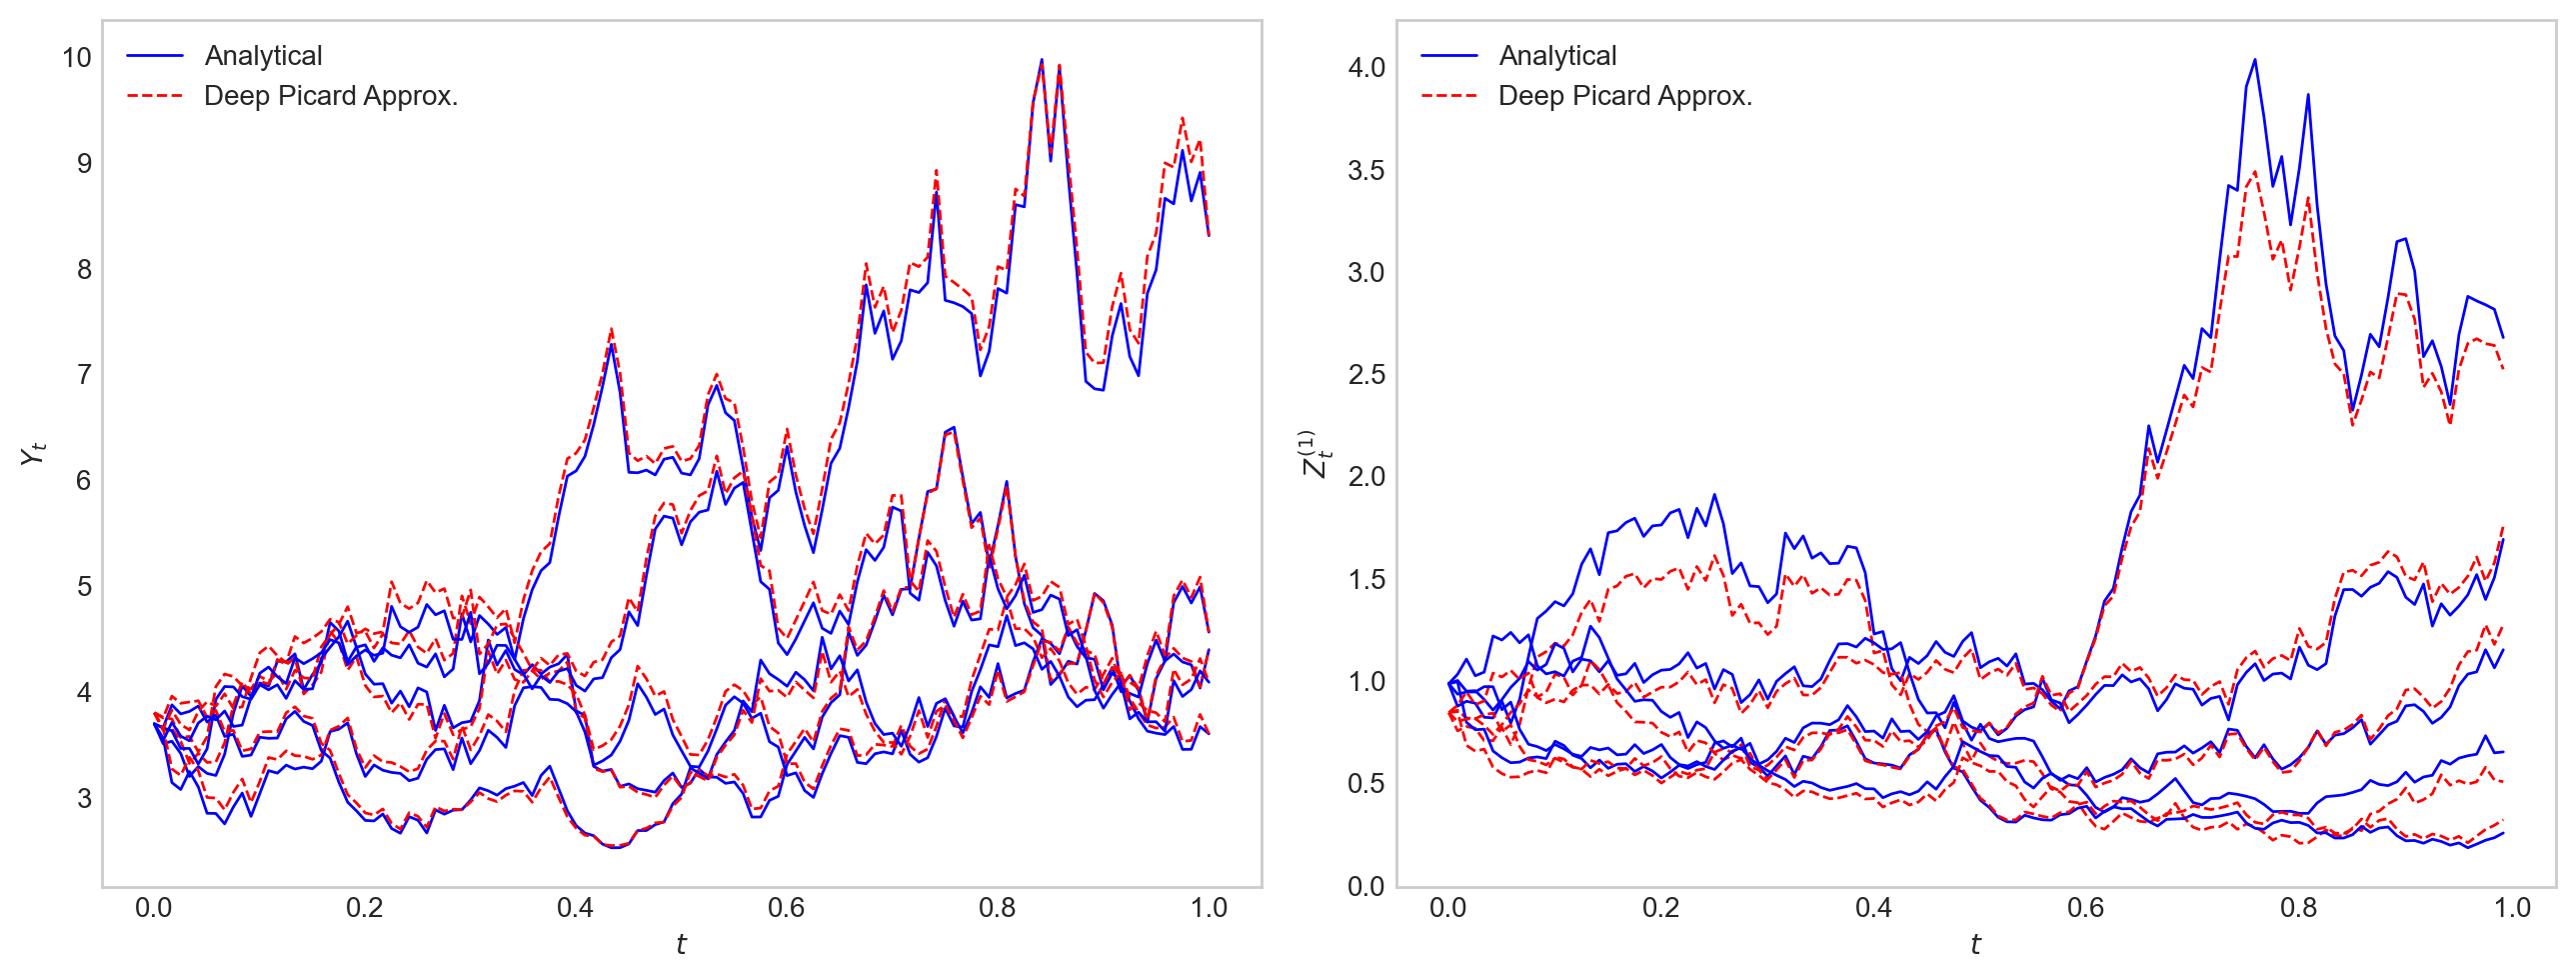

In [7]:
## 4. Visualization
# We wrap the benchmark's analytical methods to match the signature expected by the plotter.

def analytical_y_wrapper(t, x, **kwargs):
    # Pass T explicitly as required by the Equation class
    return eqn.analytical_y(t, x, T=solver_cfg.T)

def analytical_z_wrapper(t, x, **kwargs):
    return eqn.analytical_z(t, x, T=solver_cfg.T)

# Plot pathwise comparison
fig, axes = plot_pathwise_comparison(
    solution=solution,
    analytical_Y_func=analytical_y_wrapper,
    analytical_Z_func=analytical_z_wrapper,
    component_idx=0
)

plt.show()

## Hure Example

In [4]:
## 1. Configuration

DIM_X = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running Hure Benchmark (d={DIM_X}) on {DEVICE}")

# Solver Settings
solver_cfg = SolverConfig(
    T=1.0,
    N=100,                 
    num_paths=8000,        
    picard_iterations=5,   
    z_method='gradient',   
    device=DEVICE
)

# Training Settings
# Hure et al. is smoother than BSB, so standard learning rate 1e-3 often works well.
train_cfg = TrainingConfig(
    batch_size=500,        
    epochs=5,             
    learning_rate=1e-4,    
    lr_decay_step=2000,
    verbose=True
)

## 2. Equation & Networks Setup

# 1. Physics: Hure Equation
eqn = HureEquation(dim_x=DIM_X)

# 2. Topology: Neural Networks
input_dim = 1 + DIM_X 
hidden_layers = [40, 40, 40, 40] 

# Network for Y
nn_Y = MLP(input_dim=input_dim, output_dim=eqn.dim_y, hidden_dims=hidden_layers)

# Network for Z (Required only if z_method == 'regression')
nn_Z = None
if solver_cfg.z_method == 'regression':
    output_dim_z = eqn.dim_y * eqn.dim_w
    nn_Z = MLP(input_dim=input_dim, output_dim=output_dim_z, hidden_dims=hidden_layers)

## 3. Instantiate and Run Solver

solver = UncoupledFBSDESolver(
    equation=eqn,
    solver_config=solver_cfg,
    training_config=train_cfg, 
    nn_Y=nn_Y,
    nn_Z=nn_Z
)

solution = solver.solve()

2026-02-01 15:58:04 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (gradient)...


Running Hure Benchmark (d=3) on cpu


2026-02-01 15:58:09 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/5: Error=1.2049e+00 | Mean Y_Loss=2.9259e-01
2026-02-01 15:58:15 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/5: Error=1.0054e-01 | Mean Y_Loss=2.4739e-01
2026-02-01 15:58:20 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/5: Error=1.9106e-02 | Mean Y_Loss=2.4610e-01
2026-02-01 15:58:24 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 4/5: Error=2.6823e-02 | Mean Y_Loss=2.4719e-01
2026-02-01 15:58:29 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 5/5: Error=2.2981e-02 | Mean Y_Loss=2.4787e-01


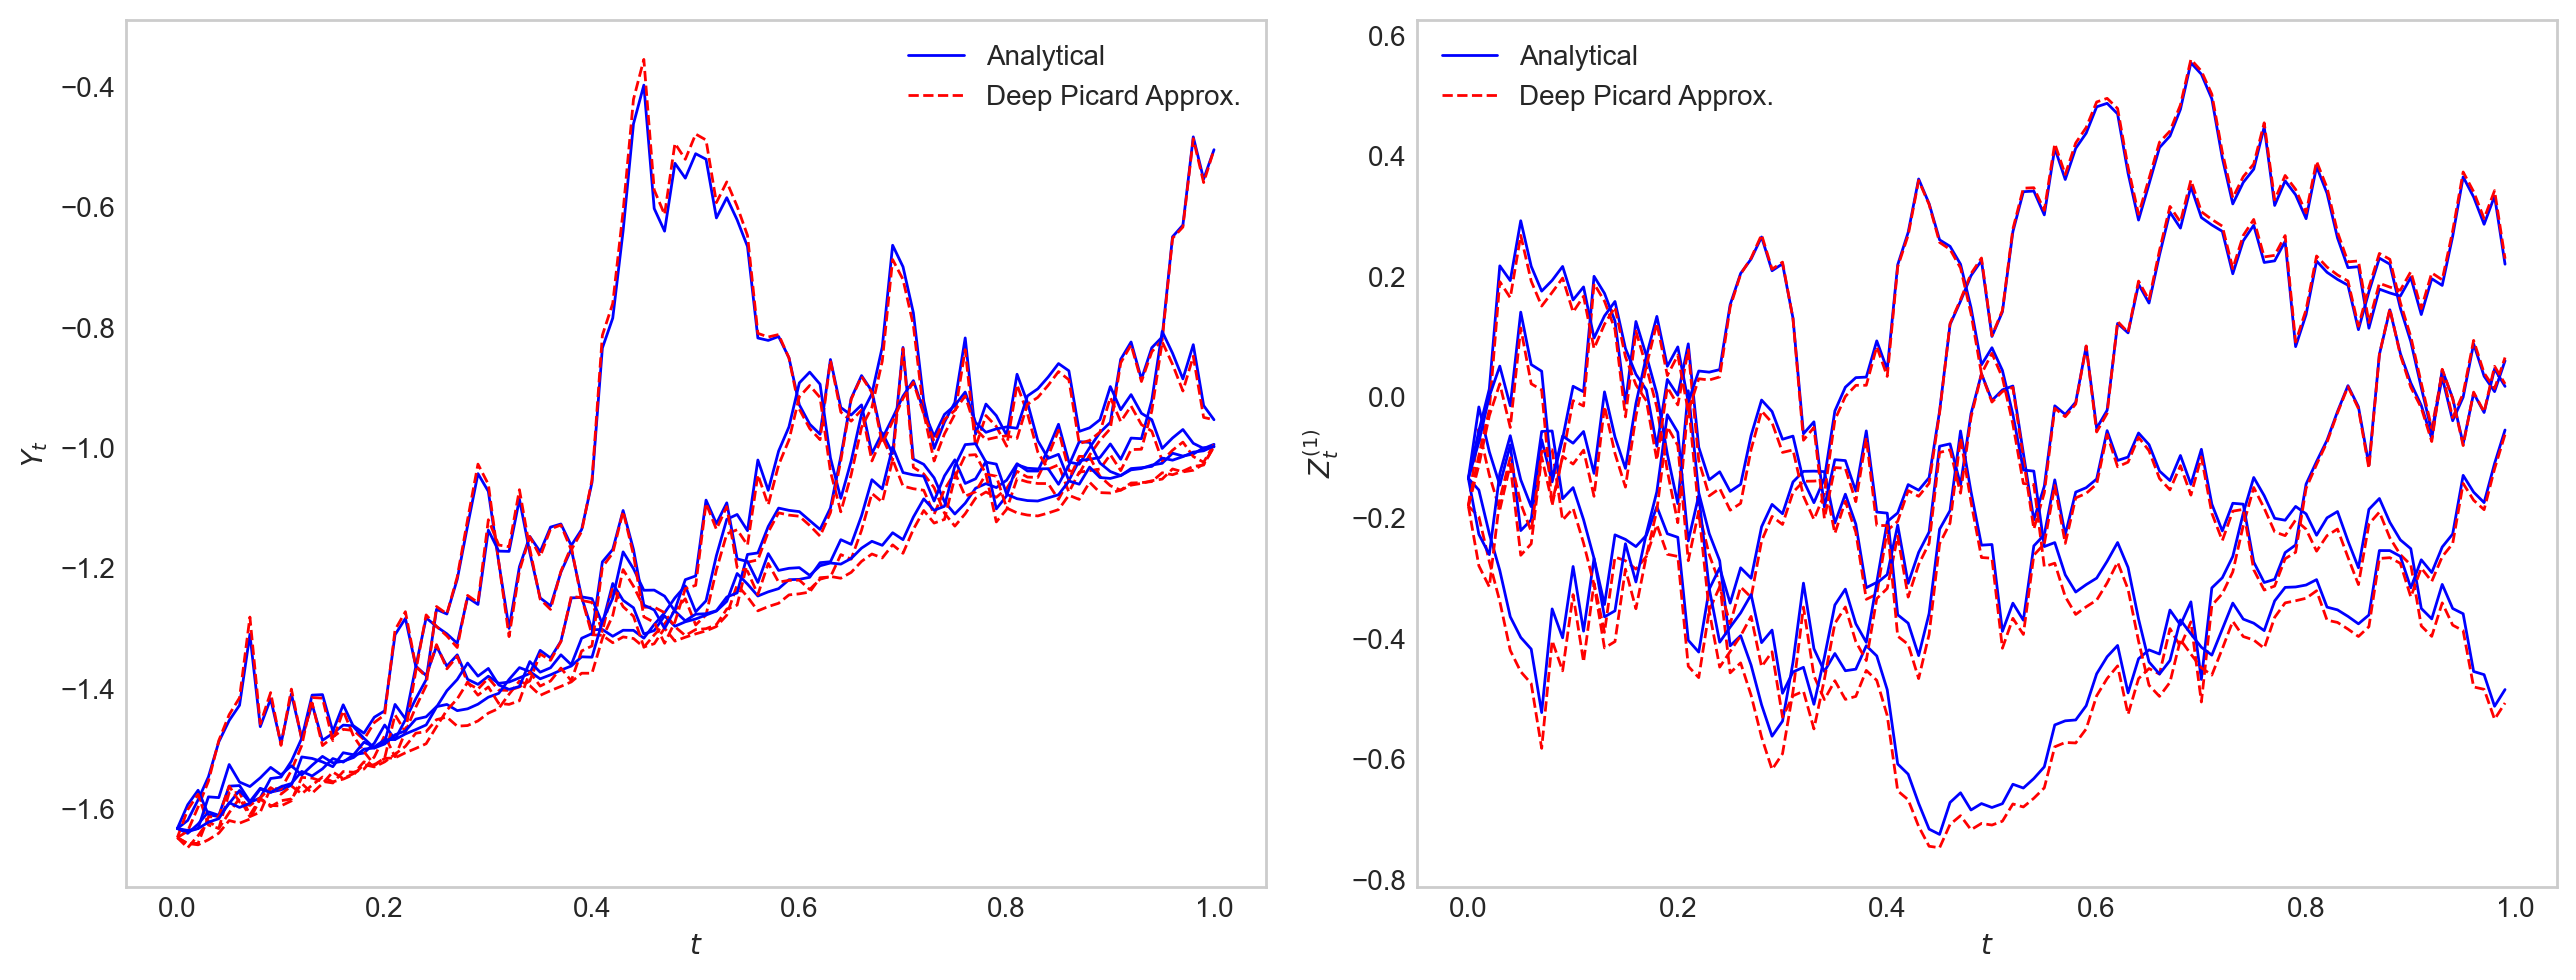

In [5]:
## 4. Visualization

# Wrap analytical functions to pass 'T' explicitly
def analytical_y_wrapper(t, x, **kwargs):
    return eqn.analytical_y(t, x, T=solver_cfg.T)

def analytical_z_wrapper(t, x, **kwargs):
    return eqn.analytical_z(t, x, T=solver_cfg.T)

# Plot pathwise comparison
fig, axes = plot_pathwise_comparison(
    solution=solution,
    analytical_Y_func=analytical_y_wrapper,
    analytical_Z_func=analytical_z_wrapper,
    component_idx=0
)
plt.show()

## Z-Coupled Example

In [6]:
## 1. Configuration

DIM_X = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running Coupled Benchmark (d={DIM_X}) on {DEVICE}")

# Solver Settings
# Note: picard_iterations here refers to the GLOBAL iterations (k)
solver_cfg = SolverConfig(
    T=1.0,
    N=120,
    num_paths=3000,
    global_iterations=3,  # Number of Forward-Backward Sweeps
    picard_iterations=3,   # Number of Training Steps PER global sweep
    z_method='regression',
    device=DEVICE
)

# Training Settings for the INNER solver
# In each global step, we train the networks slightly to adjust to the new X paths
train_cfg = TrainingConfig(
    batch_size=256,
    epochs=5,              # Epochs per inner step
    learning_rate=1e-3,    # Standard LR for this smooth problem
    lr_decay_step=1000,
    verbose=True          # Turn off inner verbosity to avoid spam
)

# ## 2. Equation & Networks Setup

# 1. Physics: Z-Coupled Equation
eqn = ZCoupledEquation(dim_x=DIM_X)

# 2. Topology: Neural Networks
input_dim = 1 + DIM_X 
hidden_layers = [64, 64, 64] 

# Network for Y
nn_Y = MLP(input_dim=input_dim, output_dim=eqn.dim_y, hidden_dims=hidden_layers)

# Network for Z (Required only if regression)
nn_Z = None
if solver_cfg.z_method == 'regression':
    output_dim_z = eqn.dim_y * eqn.dim_w
    nn_Z = MLP(input_dim=input_dim, output_dim=output_dim_z, hidden_dims=hidden_layers)

## 3. Instantiate and Run Coupled Solver

# Note: We use CoupledFBSDESolver here
solver = CoupledFBSDESolver(
    equation=eqn,
    solver_config=solver_cfg,
    training_config=train_cfg,
    nn_Y=nn_Y,
    nn_Z=nn_Z
)

solution = solver.solve()

2026-02-01 15:59:01 - dim_fbsde.solvers.coupled - INFO - Starting Coupled Solver (Global Iters: 3, Inner Iters: 3)...
2026-02-01 15:59:01 - dim_fbsde.solvers.coupled - INFO - 
--- Global Iteration 1/3 ---
2026-02-01 15:59:01 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (regression)...


Running Coupled Benchmark (d=3) on cpu


2026-02-01 15:59:07 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/3: Error=7.1151e-01 | Mean Y_Loss=2.6646e-01
2026-02-01 15:59:13 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/3: Error=2.1160e-01 | Mean Y_Loss=3.6460e-01
2026-02-01 15:59:19 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/3: Error=7.0777e-02 | Mean Y_Loss=3.8480e-01
2026-02-01 15:59:19 - dim_fbsde.solvers.coupled - INFO - Global Error (Y_k vs Y_k-1): 9.3822e-01
2026-02-01 15:59:19 - dim_fbsde.solvers.coupled - INFO - 
--- Global Iteration 2/3 ---
2026-02-01 15:59:19 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (regression)...
2026-02-01 15:59:25 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/3: Error=6.7171e-02 | Mean Y_Loss=3.9023e-01
2026-02-01 15:59:32 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/3: Error=7.6552e-02 | Mean Y_Loss=3.9117e-01
2026-02-01 15:59:38 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/3: Error=2.2273e-02 | Mean Y_Loss=3.9670e-01
2026-02

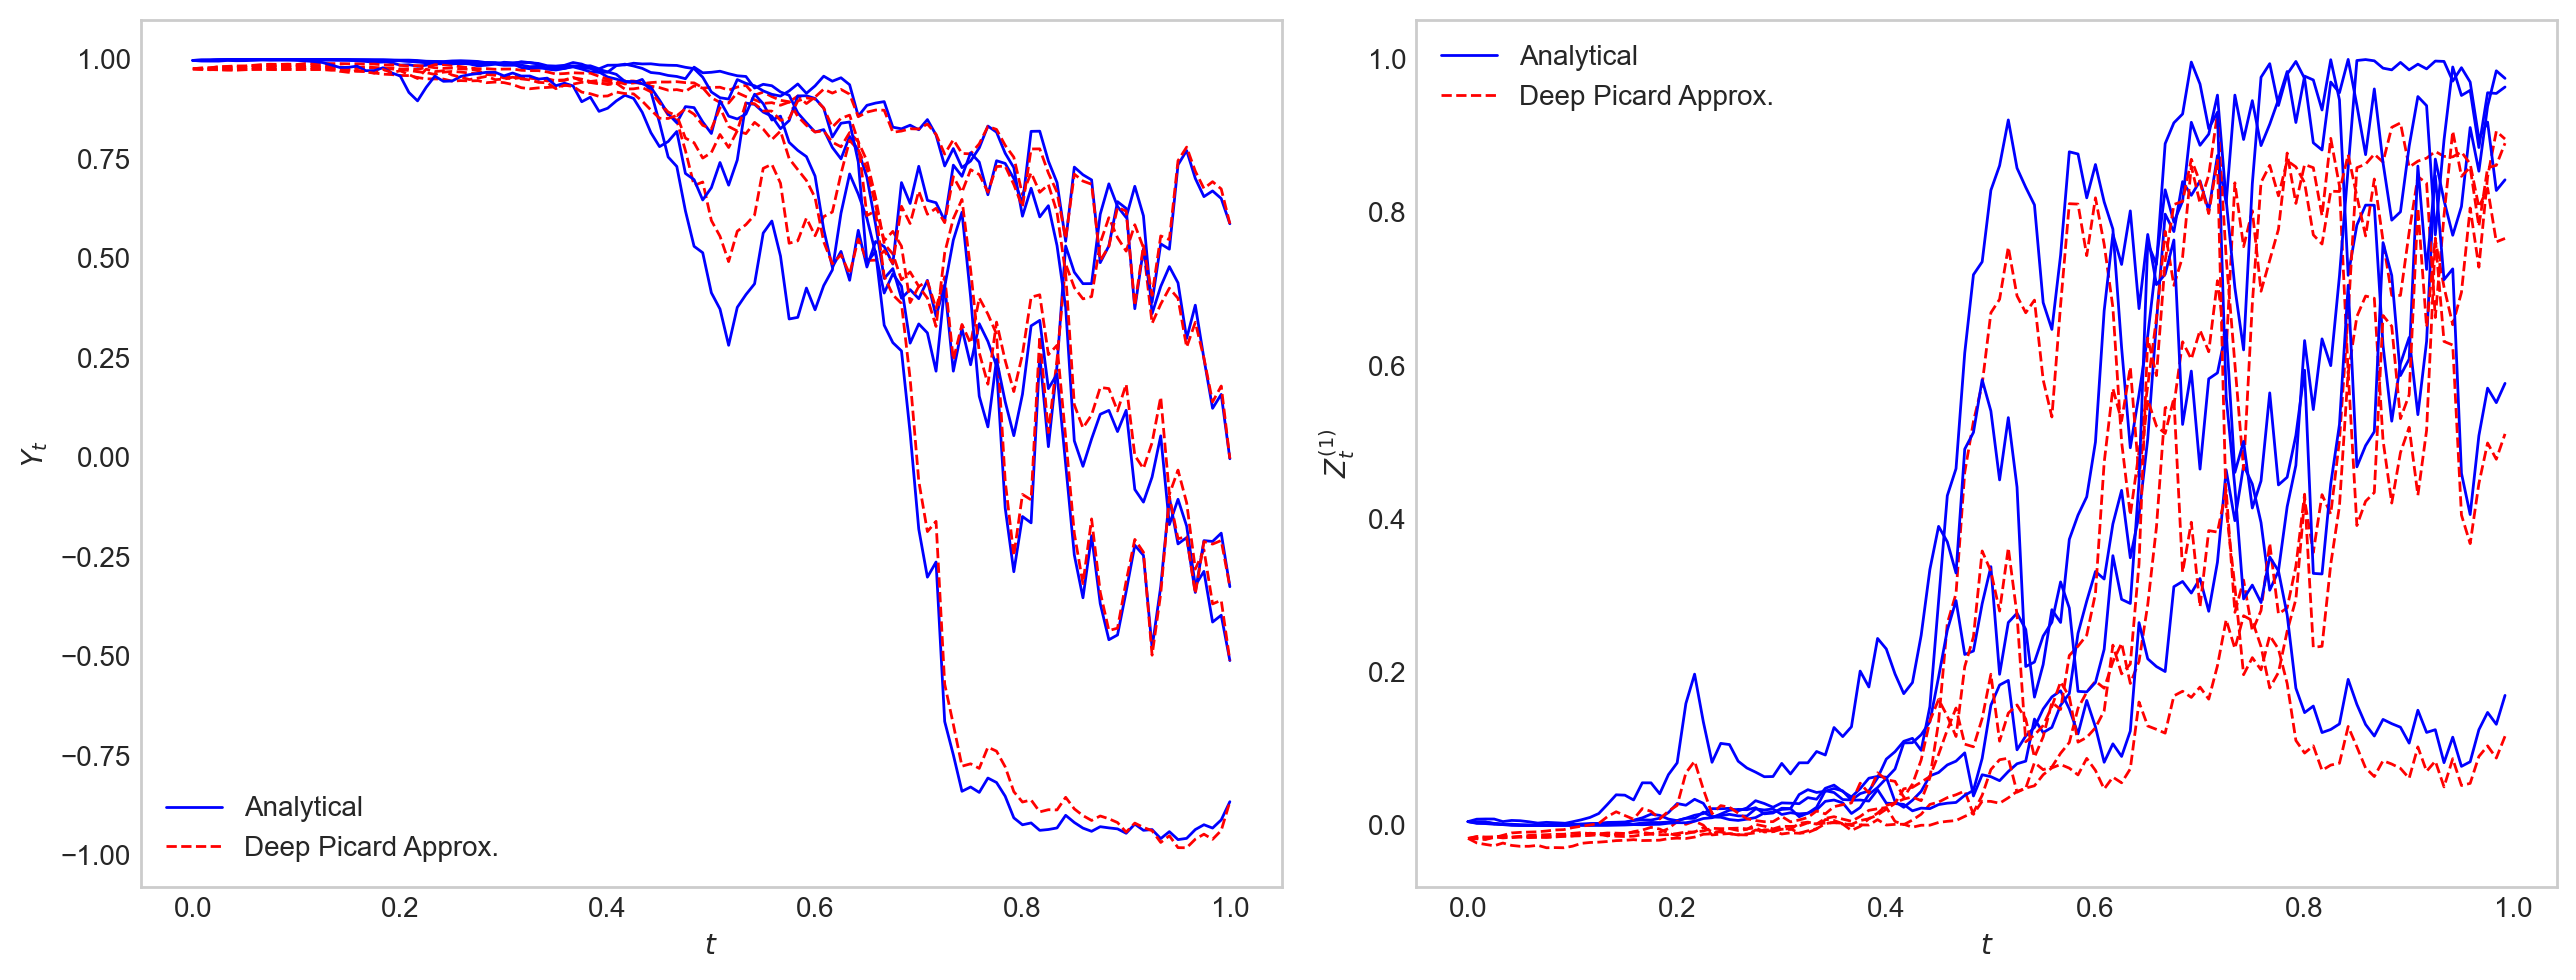

In [7]:
## 4. Visualization

# Wrap analytical functions
def analytical_y_wrapper(t, x, **kwargs):
    return eqn.analytical_y(t, x, T=solver_cfg.T)

def analytical_z_wrapper(t, x, **kwargs):
    return eqn.analytical_z(t, x, T=solver_cfg.T)

# Plot pathwise comparison
fig, axes = plot_pathwise_comparison(
    solution=solution,
    analytical_Y_func=analytical_y_wrapper,
    analytical_Z_func=analytical_z_wrapper,
    component_idx=0
)

plt.show()

## Fully-Coupled Example

In [9]:
## 1. Configuration

DIM_X = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running Fully Coupled Benchmark (d={DIM_X}) on {DEVICE}")

# Solver Settings
solver_cfg = SolverConfig(
    T=1.0,
    N=120,
    num_paths=5000,
    global_iterations=5,   # Outer training steps
    picard_iterations=5,   # Inner training steps
    z_method='gradient',   
    device=DEVICE
)

# Training Settings
train_cfg = TrainingConfig(
    batch_size=500,
    epochs=5,              
    learning_rate=1e-4,    
    lr_decay_step=1000,
    verbose=True
)


## 2. Equation & Networks Setup

# 1. Physics: Fully Coupled Equation
eqn = FullyCoupledEquation(dim_x=DIM_X)

# 2. Topology: Neural Networks
input_dim = 1 + DIM_X 
hidden_layers = [64, 64, 64] 

# Network for Y
nn_Y = MLP(input_dim=input_dim, output_dim=eqn.dim_y, hidden_dims=hidden_layers)

# Network for Z (Required only if regression)
nn_Z = None
if solver_cfg.z_method == 'regression':
    output_dim_z = eqn.dim_y * eqn.dim_w
    nn_Z = MLP(input_dim=input_dim, output_dim=output_dim_z, hidden_dims=hidden_layers)


## 3. Instantiate and Run Coupled Solver

solver = CoupledFBSDESolver(
    equation=eqn,
    solver_config=solver_cfg,
    training_config=train_cfg,
    nn_Y=nn_Y,
    nn_Z=nn_Z
)

solution = solver.solve()

2026-02-01 16:04:14 - dim_fbsde.solvers.coupled - INFO - Starting Coupled Solver (Global Iters: 5, Inner Iters: 5)...
2026-02-01 16:04:14 - dim_fbsde.solvers.coupled - INFO - 
--- Global Iteration 1/5 ---
2026-02-01 16:04:14 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (gradient)...


Running Fully Coupled Benchmark (d=1) on cpu


2026-02-01 16:04:18 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/5: Error=6.0301e-01 | Mean Y_Loss=6.0756e-02
2026-02-01 16:04:22 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/5: Error=6.6666e-02 | Mean Y_Loss=5.6621e-02
2026-02-01 16:04:26 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/5: Error=5.8986e-02 | Mean Y_Loss=5.9841e-02
2026-02-01 16:04:30 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 4/5: Error=2.7023e-02 | Mean Y_Loss=5.9249e-02
2026-02-01 16:04:34 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 5/5: Error=9.4852e-03 | Mean Y_Loss=5.8436e-02
2026-02-01 16:04:34 - dim_fbsde.solvers.coupled - INFO - Global Error (Y_k vs Y_k-1): 6.1866e-01
2026-02-01 16:04:34 - dim_fbsde.solvers.coupled - INFO - 
--- Global Iteration 2/5 ---
2026-02-01 16:04:34 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (gradient)...
2026-02-01 16:04:38 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/5: Error=1.7261e-01 | Mean Y_Loss=1.7139e-01
2026-02-0

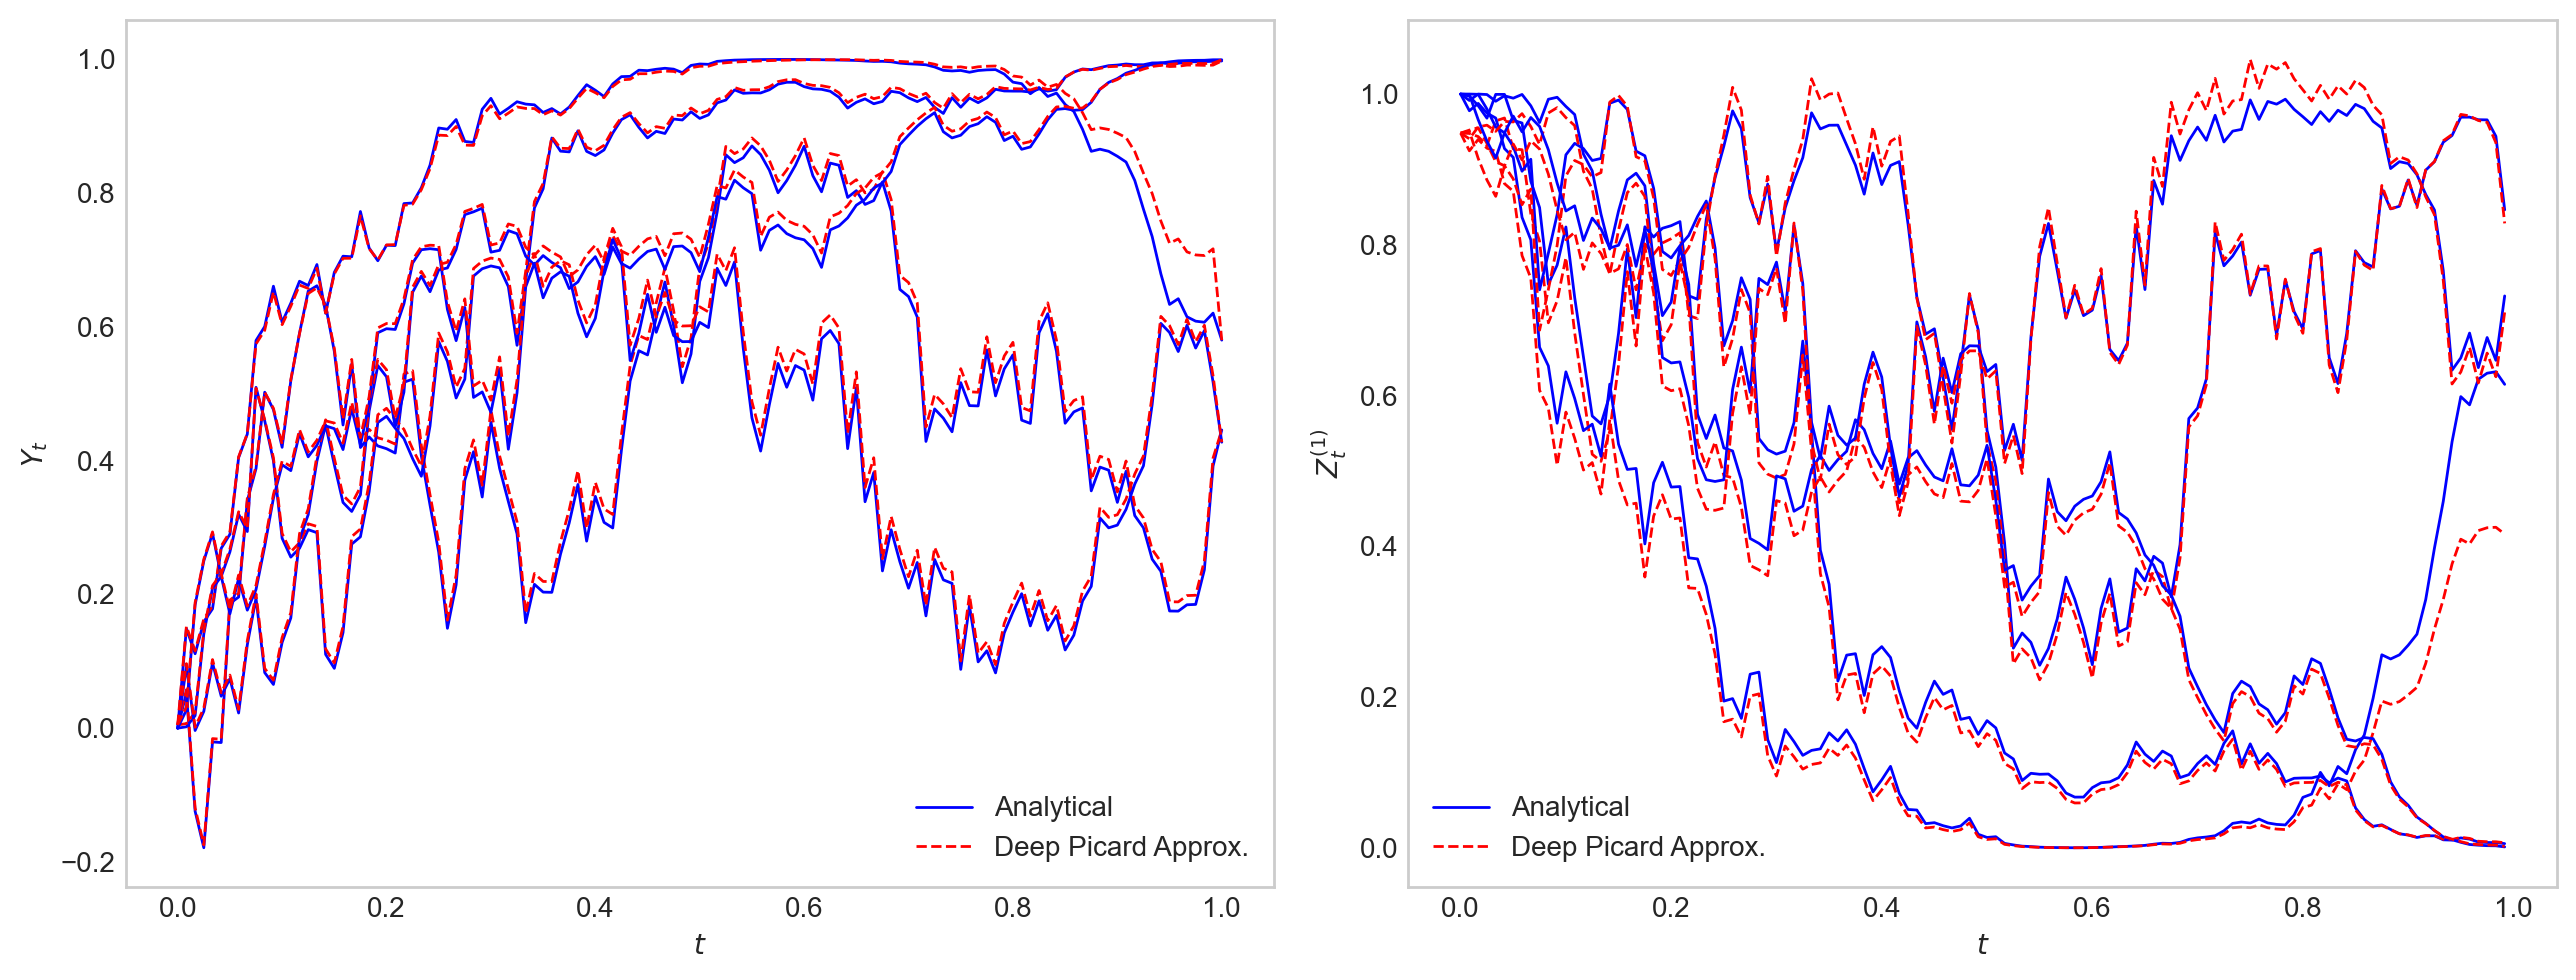

In [15]:
## 4. Visualization

# Wrap analytical functions
def analytical_y_wrapper(t, x, **kwargs):
    return eqn.analytical_y(t, x, T=solver_cfg.T)

def analytical_z_wrapper(t, x, **kwargs):
    return eqn.analytical_z(t, x, T=solver_cfg.T)

# Plot pathwise comparison
fig, axes = plot_pathwise_comparison(
    solution=solution,
    analytical_Y_func=analytical_y_wrapper,
    analytical_Z_func=analytical_z_wrapper,
    component_idx=0
)

plt.show()

## MV-FBSDE Example

In [25]:
## 1. Configuration

DIM_X = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running McKean-Vlasov Benchmark (d={DIM_X}) on {DEVICE}")

# Solver Settings
solver_cfg = SolverConfig(
    T=1.0,
    N=120,
    num_paths=8000,        
    global_iterations=3,  
    picard_iterations=3,   
    z_method='regression',   
    device=DEVICE
)

# Training Settings
train_cfg = TrainingConfig(
    batch_size=1000,
    epochs=5,
    learning_rate=5e-4,  
    lr_decay_step=1000,
    verbose=True
)


## 2. Equation & Networks Setup

# 1. Physics: McKean-Vlasov Equation
eqn = McKeanVlasovEquation(dim_x=DIM_X)

# 2. Topology: Neural Networks
input_dim = 1 + DIM_X 
hidden_layers = [64, 64, 64] 

# Network for Y
nn_Y = MLP(input_dim=input_dim, output_dim=eqn.dim_y, hidden_dims=hidden_layers)

# Network for Z
nn_Z = None
if solver_cfg.z_method == 'regression':
    output_dim_z = eqn.dim_y * eqn.dim_w
    nn_Z = MLP(input_dim=input_dim, output_dim=output_dim_z, hidden_dims=hidden_layers)


## 3. Instantiate and Run Solver

solver = McKeanVlasovSolver(
    equation=eqn,
    solver_config=solver_cfg,
    training_config=train_cfg,
    nn_Y=nn_Y,
    nn_Z=nn_Z
)

solution = solver.solve()

2026-02-01 16:21:06 - dim_fbsde.solvers.mckean_vlasov - INFO - Starting McKean-Vlasov Solver (Global Iters: 3)...
2026-02-01 16:21:06 - dim_fbsde.solvers.mckean_vlasov - INFO - 
--- Global Iteration 1/3 ---


Running McKean-Vlasov Benchmark (d=1) on cpu


2026-02-01 16:21:21 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (regression)...
2026-02-01 16:21:29 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/3: Error=9.0483e-01 | Mean Y_Loss=1.7856e-01
2026-02-01 16:21:37 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/3: Error=3.6253e-01 | Mean Y_Loss=2.7704e-01
2026-02-01 16:21:44 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 3/3: Error=1.8650e-01 | Mean Y_Loss=2.7743e-01
2026-02-01 16:21:44 - dim_fbsde.solvers.mckean_vlasov - INFO - Global Error (Y_k vs Y_k-1): 5.4858e-01
2026-02-01 16:21:44 - dim_fbsde.solvers.mckean_vlasov - INFO - 
--- Global Iteration 2/3 ---
2026-02-01 16:22:00 - dim_fbsde.solvers.uncoupled - INFO - Starting Uncoupled Solver (regression)...
2026-02-01 16:22:07 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 1/3: Error=2.6743e-02 | Mean Y_Loss=2.5675e-01
2026-02-01 16:22:16 - dim_fbsde.solvers.uncoupled - INFO - Picard Iter 2/3: Error=6.7715e-02 | Mean Y_Loss=2.5454e-01
2026-02-01 1

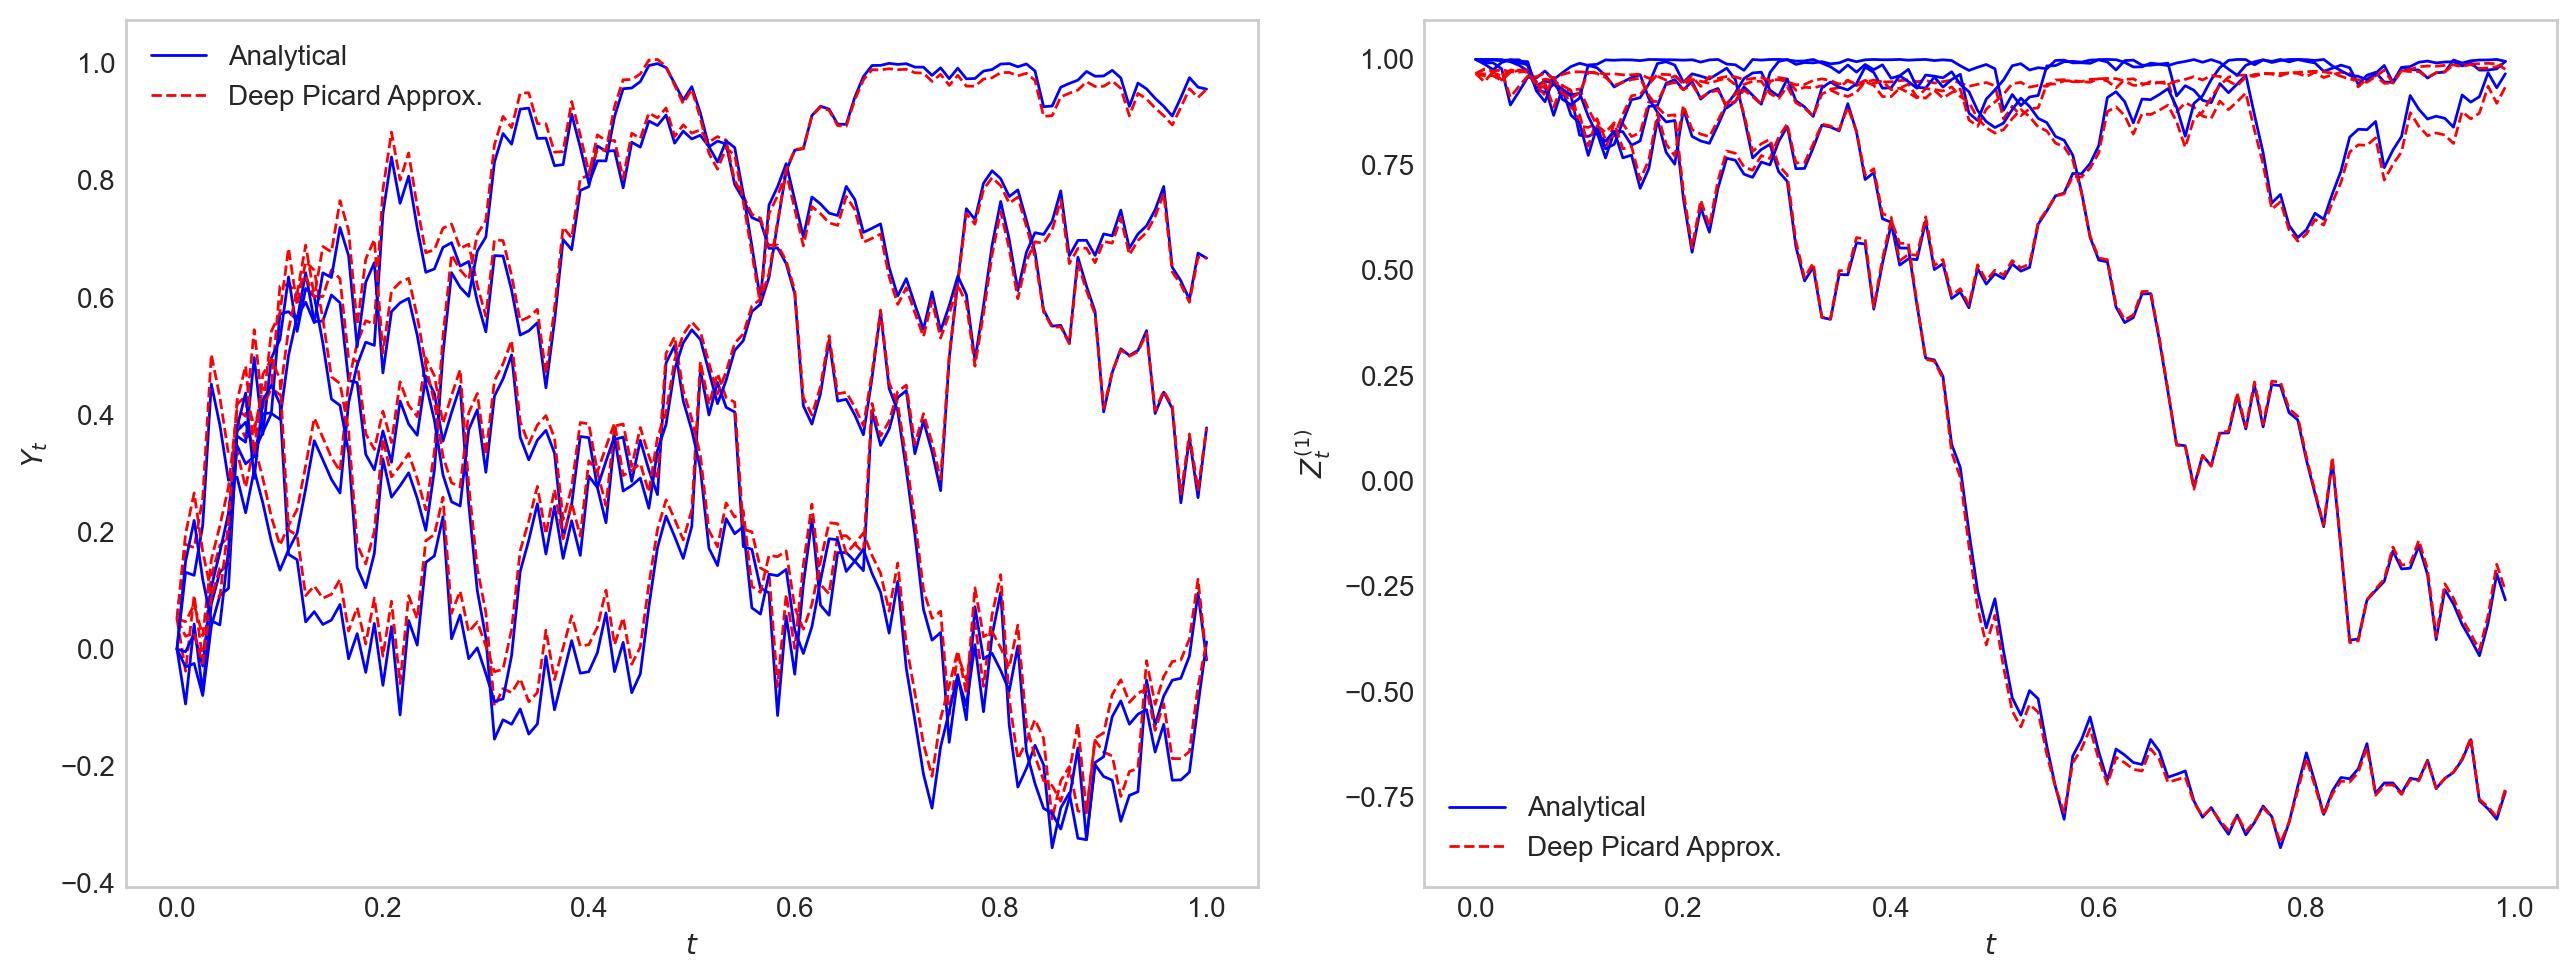

In [26]:
## 4. Visualization

# Wrap analytical functions
def analytical_y_wrapper(t, x, **kwargs):
    return eqn.analytical_y(t, x, T=solver_cfg.T)

def analytical_z_wrapper(t, x, **kwargs):
    return eqn.analytical_z(t, x, T=solver_cfg.T)

# Plot pathwise comparison
fig, axes = plot_pathwise_comparison(
    solution=solution,
    analytical_Y_func=analytical_y_wrapper,
    analytical_Z_func=analytical_z_wrapper,
    component_idx=0
)

plt.show()